In [35]:
# %load_ext autoreload
# %autoreload 2

In [36]:
import torch
import functorch as ft
from torch import nn

In [37]:
from sklearn.datasets import make_moons
from models.normalizing_flow import NormalizingFlow
from models.planar import planar


In [38]:
X, _ = make_moons()

In [39]:
flows = planar(num_layers=16, input_dim=2)

In [40]:
model = NormalizingFlow(None, flows)

In [41]:
# model(torch.randn(2, 2))

In [42]:
fnmodel, params, buffers = ft.make_functional_with_buffers(model)

In [43]:
fnmodel(params, buffers, torch.randn(2, 2))

tensor([-6.4393, -6.6047], grad_fn=<AddBackward0>)

In [44]:
def flatten(params):
    return torch.cat([p.flatten() for p in params])


def unflatten(model, flattened_params):
    if flattened_params.dim() != 1:
        raise ValueError('Expecting a 1d flattened_params')
    params_list = []
    i = 0
    for val in list(model.parameters()):
        length = val.nelement()
        param = flattened_params[i:i+length].view_as(val)
        params_list.append(nn.Parameter(param))
        i += length

    return tuple(params_list)

In [45]:
params_flat = flatten(params)

In [46]:
unflatten(model, params_flat)

(Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([ 0.1254, -0.6576], requires_grad=True),
 Parameter containing:
 tensor([-0.3445, -0.4199], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([-0.3433,  0.0818], requires_grad=True),
 Parameter containing:
 tensor([-0.1573,  0.2040], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([-0.0260,  0.5057], requires_grad=True),
 Parameter containing:
 tensor([0.2500, 0.5793], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([-0.2948,  0.5515], requires_grad=True),
 Parameter containing:
 tensor([ 0.3554, -0.2715], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([-0.5571, -0.0545], requires_grad=True),
 Parameter containing:
 tensor([-0.4175, -0.2673], requires_grad

In [47]:
X = torch.from_numpy(X).float()
# y = torch.from_numpy(y).long()

In [48]:
# y = torch.nn.functional.one_hot(y, 2)

In [49]:
prior = torch.distributions.Normal(torch.zeros(len(params_flat)), 32 * torch.ones(len(params_flat)))




In [50]:
def log_prob(params_flat):
    params = unflatten(model, params_flat)
    log_prob = fnmodel(params, buffers, X)
    
    
    ll = log_prob.mean()
    pl = prior.log_prob(params_flat).sum() / len(X)
    
    return ll + pl
    
    
    
    
    

In [51]:
import hamiltorch

In [52]:

N = 8192
burn = 512
N_nuts = N + burn
step_size = 2e-4
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_flat, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    desired_accept_rate=0.8,
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=False)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.0007170465542003512- |  510/8704 | 9.02        
0d:00:17:13 | 0d:00:00:00 | #################### | 8704/8704 | 8.42       
Acceptance Rate 0.92


In [53]:
samples = torch.stack(samples)

In [54]:
linspace = torch.linspace(-5, 5, 128)

In [55]:
grid = torch.meshgrid(linspace, linspace, indexing='ij')

grid = torch.stack(grid).view(2, -1).T

In [76]:
samples.shape

torch.Size([8192, 80])

In [83]:
params = tuple(p.data for p in params)

In [85]:
fnmodel(params, buffers, torch.randn(2, 2))

tensor([-6.0591, -6.1959])

In [88]:
len(unflatten(model, samples[0]))

48

In [99]:
stacked_params = [list() for _ in range(48)]


for param in samples:
    params_unflat = unflatten(model, param)
    for i, p in enumerate(params_unflat):
        stacked_params[i].append(p.data)

In [101]:
stacked_params = tuple(torch.stack(p) for p in stacked_params)

In [107]:
def log_prob(params):
    log_prob = fnmodel(params, buffers, X)
    
    
#     ll = log_prob.mean()
#     pl = prior.log_prob(params_flat).sum() / len(X)
    
    return log_prob # + pl
    
    
    
    
    

In [73]:
samples.shape

torch.Size([8192, 80])

In [74]:
fn_model_vmap(samples)

ValueError: vmap(log_prob, in_dims=(0, None), ...)(<inputs>): in_dims is not compatible with the structure of `inputs`. in_dims has structure TreeSpec(tuple, None, [*, *]) but inputs has structure TreeSpec(tuple, None, [*]).

In [22]:
with torch.no_grad():
    logprobs = fnmodel(unflatten(model, samples.mean(0)), buffers, grid)

In [23]:
probs = logprobs.exp()


In [24]:
probs = probs.view(128, 128)

In [25]:
import matplotlib.pyplot as plt

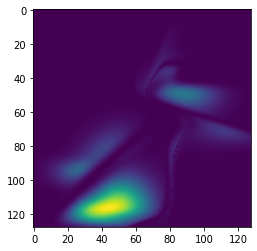

In [26]:

plt.imshow(probs)

In [110]:
models = [NormalizingFlow(None, planar(num_layers=16, input_dim=2)) for _ in range(2)]

In [111]:
fmodel, params, buffers = ft.combine_state_for_ensemble(models)


In [114]:
X.shape

torch.Size([100, 2])

In [115]:
predictions1_vmap = ft.vmap(fmodel, in_dims=(0, 0, None))(params, buffers, X)


/home/druhe/projects/gw/.venv/lib/python3.9/site-packages/torch/distributions/distribution.py:54: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::all. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:83.)
  if not valid.all():


RuntimeError: vmap: It looks like you're attempting to use a Tensor in some data-dependent control flow. We don't support that yet, please shout over at https://github.com/pytorch/functorch/issues/257 .